In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# IMPORTS
# ============================================================================

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain
import re
import umap
from sklearn.preprocessing import MultiLabelBinarizer
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# High-quality plot settings
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

print("All imports successful!")

All imports successful!


In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# File paths
DATASET_PATH = "/content/drive/MyDrive/🌟EACL 2026 🌟/EACL26-HateSpeechDataset.json"
OUTPUT_DIR = "/content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES"

# Create output directory
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Labels
INTENT_LABELS = [
    "Affective Aggression",
    "Derisive Trolling",
    "Dominance & Subjugation",
    "Ideological Expression",
    "Performative Reinforcement",
    "Strategic Incitement",
    "Threat & Intimidation"
]

IMPACT_LABELS = [
    "Disruption of Public Discourse",
    "Glorification of Hate",
    "Incitement to Discrimination/Exclusion",
    "Incitement to Violence",
    "Misinformation/Disinformation Nexus",
    "Normalization of Prejudice",
    "Psychological Harm",
    "Stigmatization & Dehumanization"
]

# Shortform mappings for plots
INTENT_LABELS_SHORT = ["AA", "DT", "D&S", "IE", "PR", "SI", "T&I"]
IMPACT_LABELS_SHORT = ["DPD", "GH", "ID/E", "IV", "M/DN", "NP", "PH", "S&D"]

print(f"Configuration loaded")
print(f"Output directory: {OUTPUT_DIR}")

Configuration loaded
Output directory: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES


In [ ]:
# ============================================================================
# LOAD DATA
# ============================================================================

with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Loaded {len(data)} samples")

# Extract components
texts = [sample['text'] for sample in data]
intent_labels = [sample['labels']['intent'] for sample in data]
impact_labels = [sample['labels']['impact'] for sample in data]

# Multi-label encoding
intent_mlb = MultiLabelBinarizer(classes=INTENT_LABELS)
impact_mlb = MultiLabelBinarizer(classes=IMPACT_LABELS)

intent_encoded = intent_mlb.fit_transform(intent_labels)
impact_encoded = impact_mlb.fit_transform(impact_labels)

print(f"Intent shape: {intent_encoded.shape}")
print(f"Impact shape: {impact_encoded.shape}")

Loaded 3296 samples
Intent shape: (3296, 7)
Impact shape: (3296, 8)


Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES/fig1_correlation_matrix.pdf


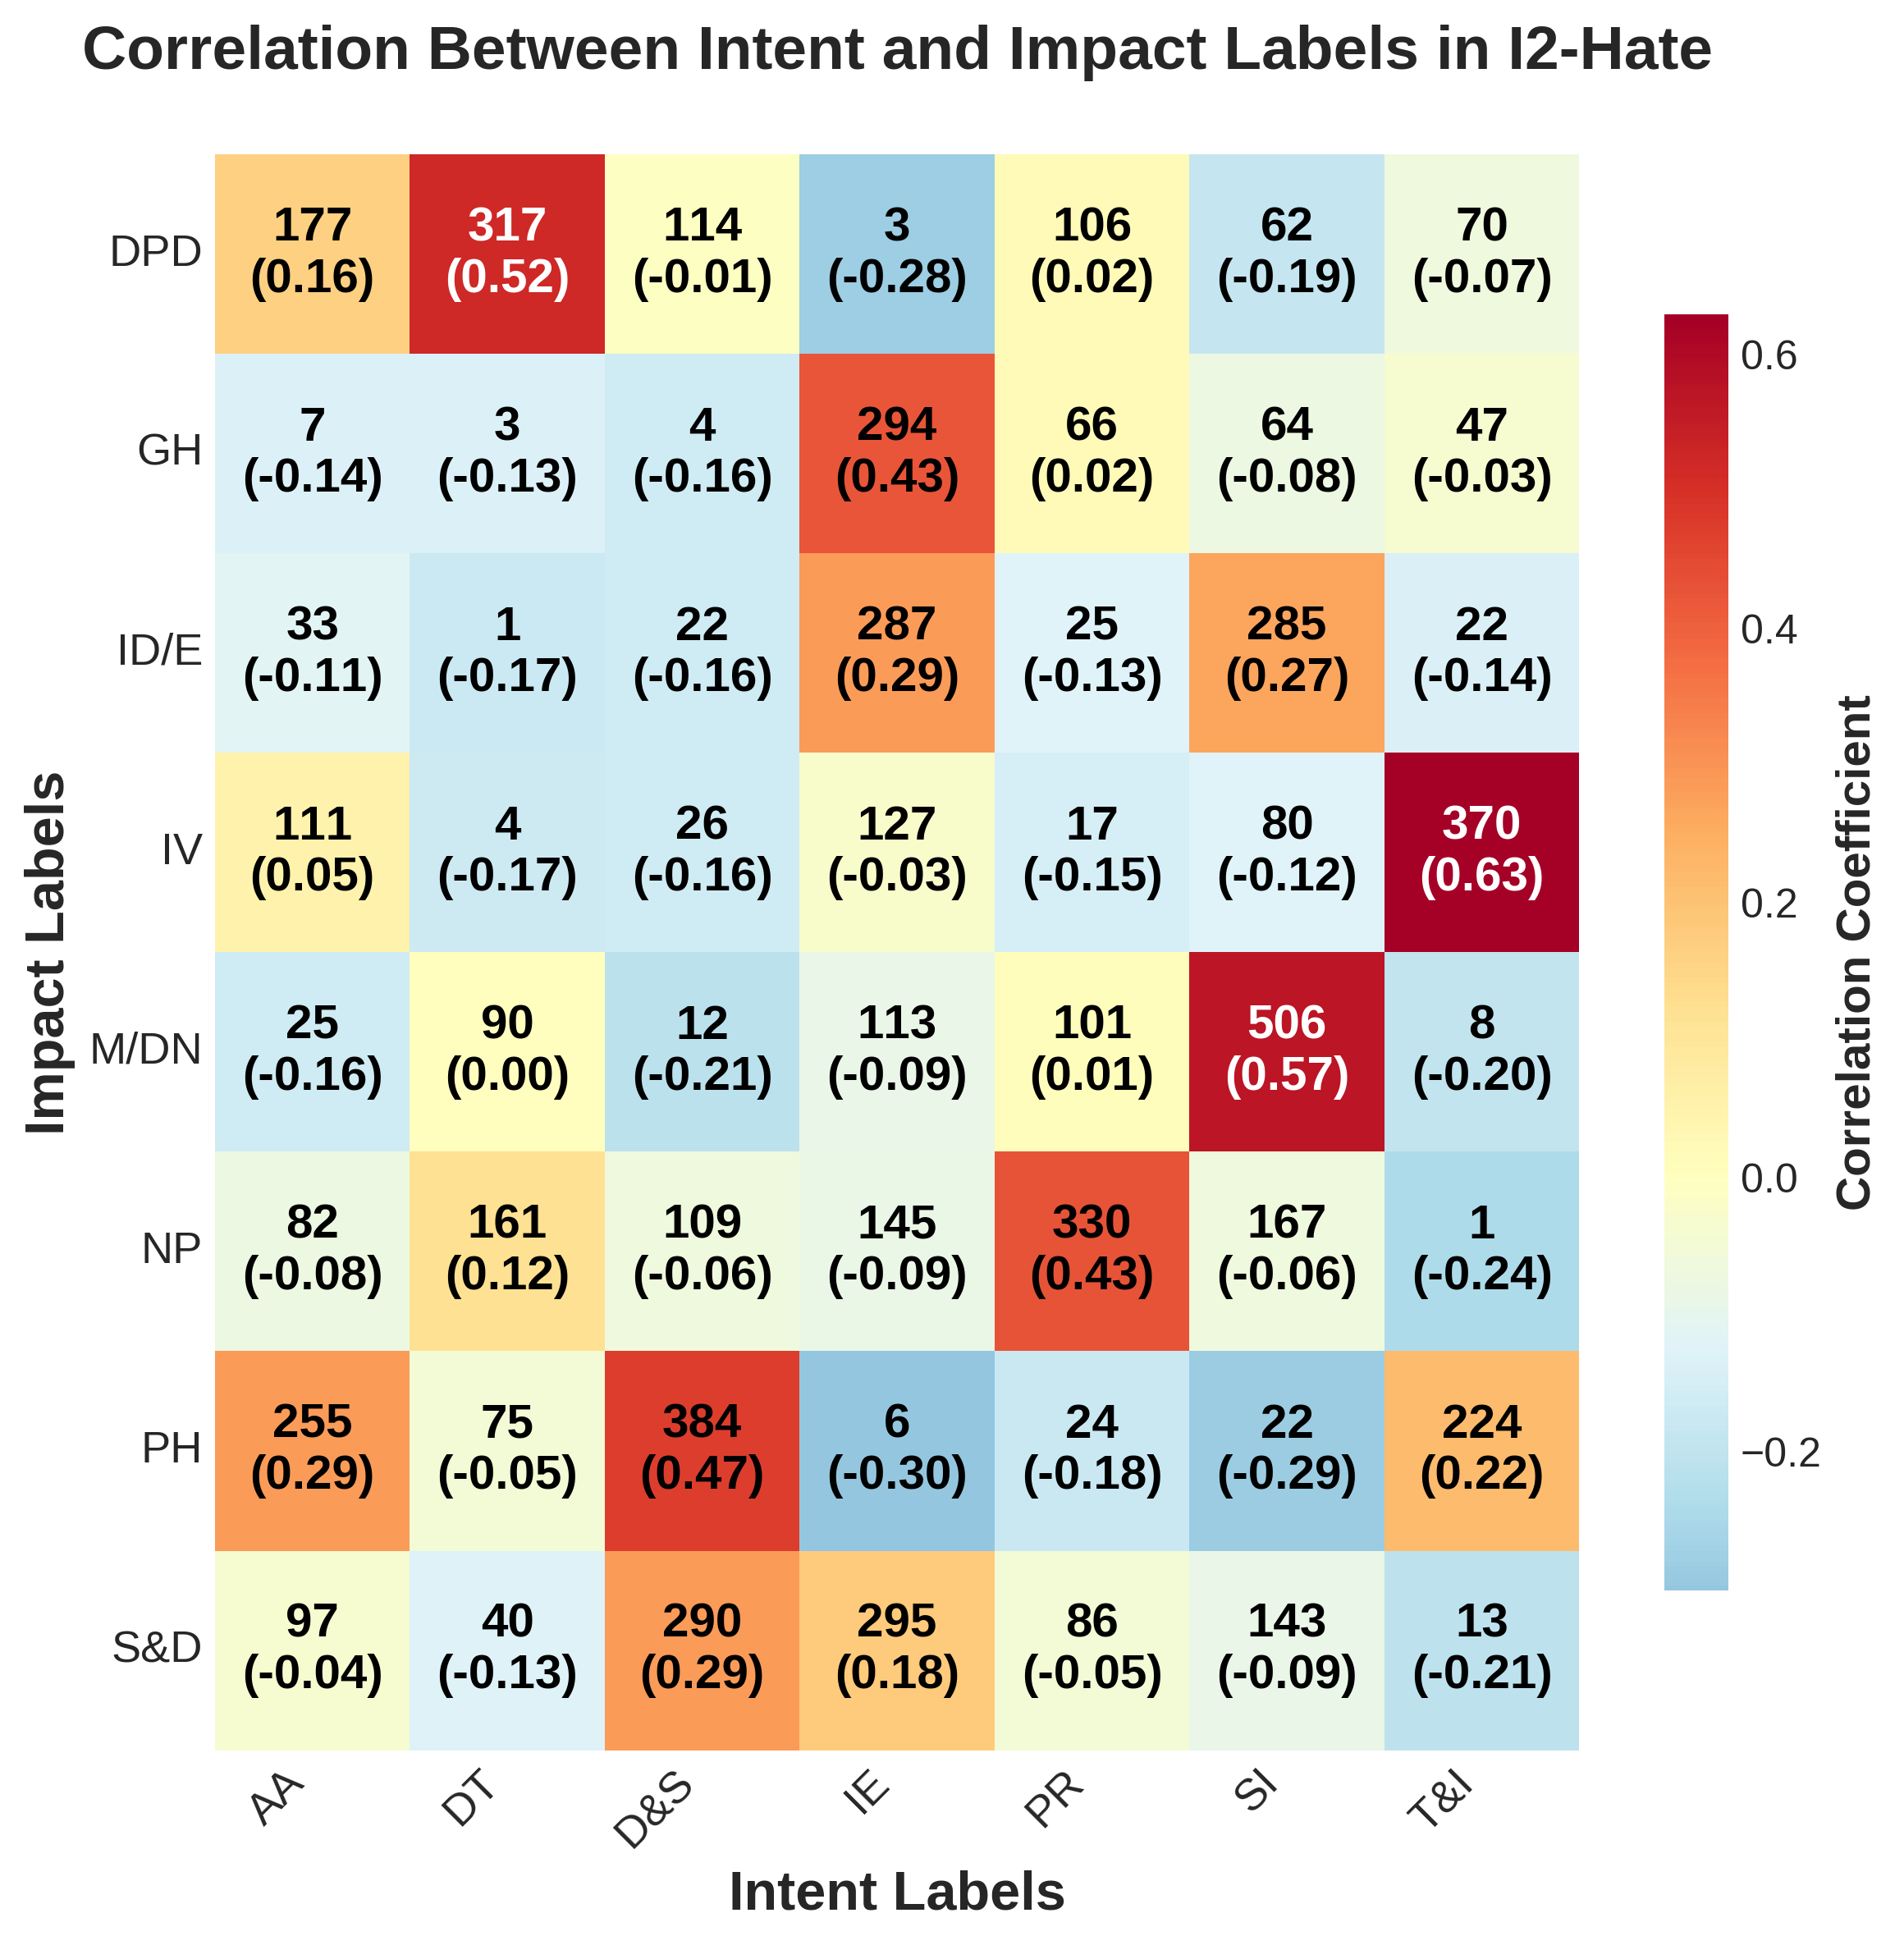

In [ ]:
# ============================================================================
# MAIN PAPER FIGURE 1: INTENT-IMPACT CORRELATION MATRIX
# ============================================================================

def create_correlation_matrix(intent_encoded, impact_encoded, intent_labels, impact_labels,
                              color_scheme='Reds', title='Correlation Between Intent and Impact Labels'):
    """
    Create correlation matrix with count and correlation coefficient.
    FLIPPED: X-axis = Intent, Y-axis = Impact
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Calculate correlation
    correlation_matrix = np.zeros((len(intent_labels), len(impact_labels)))
    count_matrix = np.zeros((len(intent_labels), len(impact_labels)))

    for i, intent_col in enumerate(intent_encoded.T):
        for j, impact_col in enumerate(impact_encoded.T):
            # Count co-occurrences
            count = np.sum(intent_col & impact_col)
            count_matrix[i, j] = count

            # Calculate Pearson correlation
            if np.std(intent_col) > 0 and np.std(impact_col) > 0:
                correlation = np.corrcoef(intent_col, impact_col)[0, 1]
            else:
                correlation = 0
            correlation_matrix[i, j] = correlation

    # TRANSPOSE matrices to flip axes
    correlation_matrix = correlation_matrix.T
    count_matrix = count_matrix.T

    # Calculate dynamic color range
    vmin = correlation_matrix.min()
    vmax = correlation_matrix.max()

    # Create heatmap with FLIPPED axes
    sns.heatmap(correlation_matrix,
                annot=False,
                fmt='.2f',
                cmap='RdYlBu_r',  # Red-Yellow-Blue diverging
                xticklabels=intent_labels,  # Intent on X-axis
                yticklabels=impact_labels,  # Impact on Y-axis
                cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
                ax=ax,
                vmin=vmin, vmax=vmax,
                center=0)

    # Add custom annotations with LARGER font
    for i in range(len(impact_labels)):
        for j in range(len(intent_labels)):
            count = int(count_matrix[i, j])
            corr = correlation_matrix[i, j]

            # Format text
            text = f'{count}\n({corr:.2f})'

            # Add text with LARGER font
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center',
                   fontsize=14,  # Increased from 8
                   color='white' if corr > 0.5 else 'black',
                   fontweight='bold')

    # LARGER fonts for all text elements
    plt.title(title, fontsize=18, fontweight='bold', pad=25)
    plt.xlabel('Intent Labels', fontsize=16, fontweight='bold')
    plt.ylabel('Impact Labels', fontsize=16, fontweight='bold')

    # Increase tick label sizes
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Increase colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Correlation Coefficient', fontsize=14, fontweight='bold')

    plt.tight_layout()

    return fig

# Generate figure
fig = create_correlation_matrix(
    intent_encoded,
    impact_encoded,
    INTENT_LABELS_SHORT,
    IMPACT_LABELS_SHORT,
    color_scheme='Reds',
    title='Correlation Between Intent and Impact Labels in I2-Hate'
)

# Save
output_path = os.path.join(OUTPUT_DIR, 'fig1_correlation_matrix.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

# Display
plt.show()

In [ ]:
# ============================================================================
# MAIN PAPER FIGURE 2: COMBINED UMAP SEMANTIC EMBEDDING (SIDE BY SIDE)
# ============================================================================


def create_combined_umap_embedding(texts, intent_encoded, impact_encoded,
                                   intent_labels, impact_labels,
                                   intent_labels_short, impact_labels_short):
    """
    Create side-by-side UMAP visualizations for intent and impact.
    """
    print(f"Generating embeddings...")

    # Load sentence transformer
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    embeddings = model.encode(texts, show_progress_bar=True)

    print(f"Reducing dimensions with UMAP...")

    # Apply UMAP
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer.fit_transform(embeddings)

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # ===== INTENT PLOT =====
    # Get dominant label for each sample
    dominant_labels_intent = []
    for sample_labels in intent_encoded:
        if sample_labels.sum() > 0:
            dominant_idx = np.argmax(sample_labels)
            dominant_labels_intent.append(intent_labels_short[dominant_idx])
        else:
            dominant_labels_intent.append('None')

    unique_labels_intent = list(set(dominant_labels_intent))
    if 'None' in unique_labels_intent:
        unique_labels_intent.remove('None')
    unique_labels_intent = sorted(unique_labels_intent)

    color_palette = plt.cm.get_cmap('tab10', len(unique_labels_intent))

    for idx, label in enumerate(unique_labels_intent):
        mask = np.array([l == label for l in dominant_labels_intent])
        ax1.scatter(embedding_2d[mask, 0],
                   embedding_2d[mask, 1],
                   label=label,
                   alpha=0.6,
                   s=40,
                   marker='o',
                   c=[color_palette(idx)])

    ax1.set_title('Semantic Clustering by Intent Labels', fontsize=16, fontweight='bold')
    ax1.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax1.set_ylabel('UMAP Dimension 2', fontsize=1)
    ax1.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax1.grid(True, alpha=0.3)

    # ===== IMPACT PLOT =====
    # Get dominant label for each sample
    dominant_labels_impact = []
    for sample_labels in impact_encoded:
        if sample_labels.sum() > 0:
            dominant_idx = np.argmax(sample_labels)
            dominant_labels_impact.append(impact_labels_short[dominant_idx])
        else:
            dominant_labels_impact.append('None')

    unique_labels_impact = list(set(dominant_labels_impact))
    if 'None' in unique_labels_impact:
        unique_labels_impact.remove('None')
    unique_labels_impact = sorted(unique_labels_impact)

    color_palette = plt.cm.get_cmap('Dark2', len(unique_labels_impact))

    for idx, label in enumerate(unique_labels_impact):
        mask = np.array([l == label for l in dominant_labels_impact])
        ax2.scatter(embedding_2d[mask, 0],
                   embedding_2d[mask, 1],
                   label=label,
                   alpha=0.6,
                   s=40,
                   marker='o',
                   c=[color_palette(idx)])

    ax2.set_title('Semantic Clustering by Impact Labels', fontsize=16, fontweight='bold')
    ax2.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax2.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax2.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig

Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/103 [00:00<?, ?it/s]

Reducing dimensions with UMAP...
Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES/fig2_umap_combined.pdf


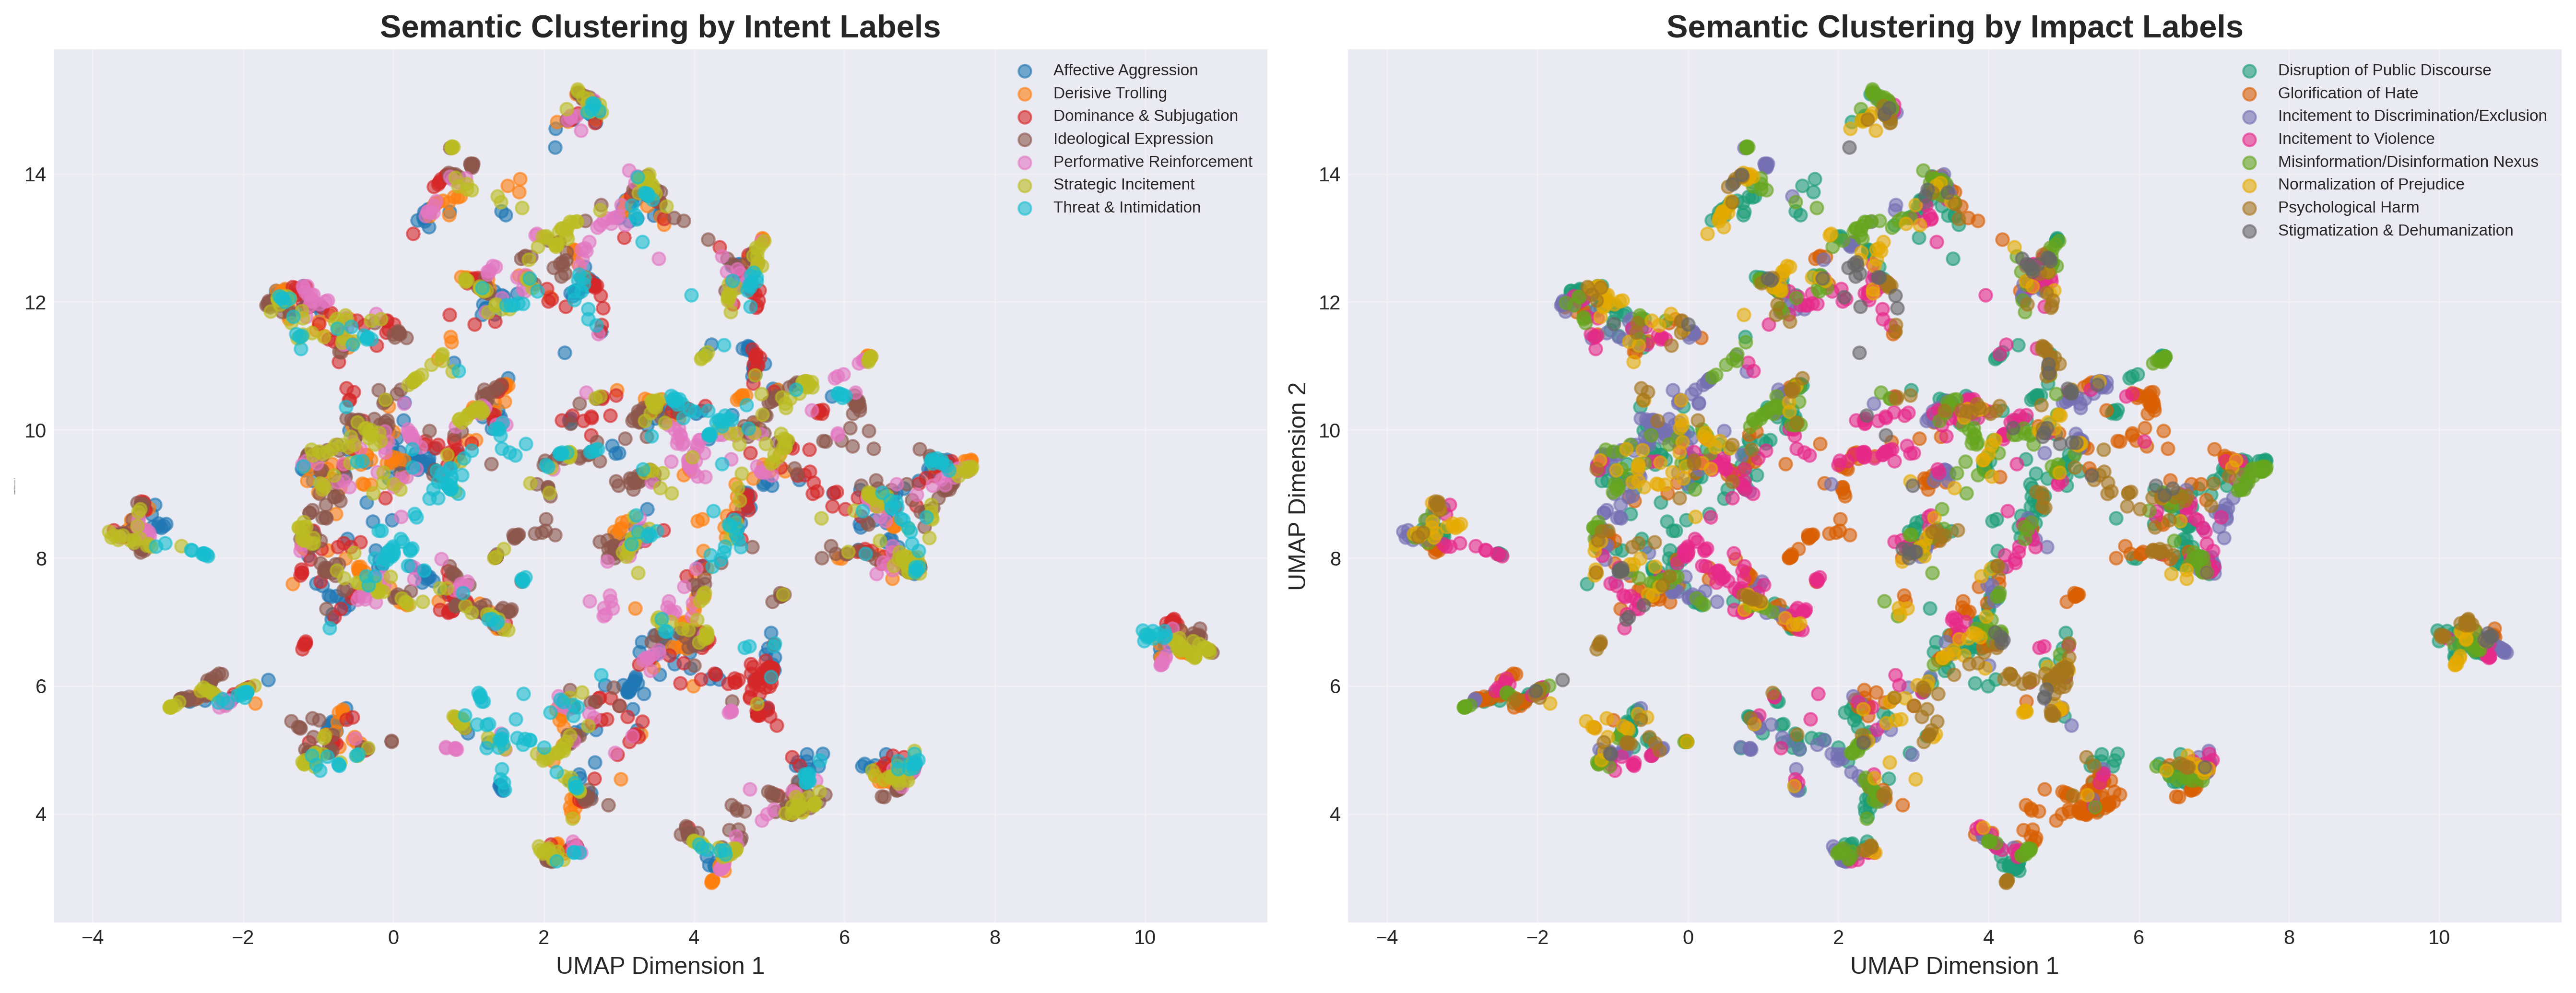

In [ ]:
# Generate combined UMAP figure
fig = create_combined_umap_embedding(
    texts,
    intent_encoded,
    impact_encoded,
    INTENT_LABELS,
    IMPACT_LABELS,
    INTENT_LABELS,
    IMPACT_LABELS
    )

# Save
output_path = os.path.join(OUTPUT_DIR, 'fig2_umap_combined.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES/appendix_a1_label_distribution.pdf


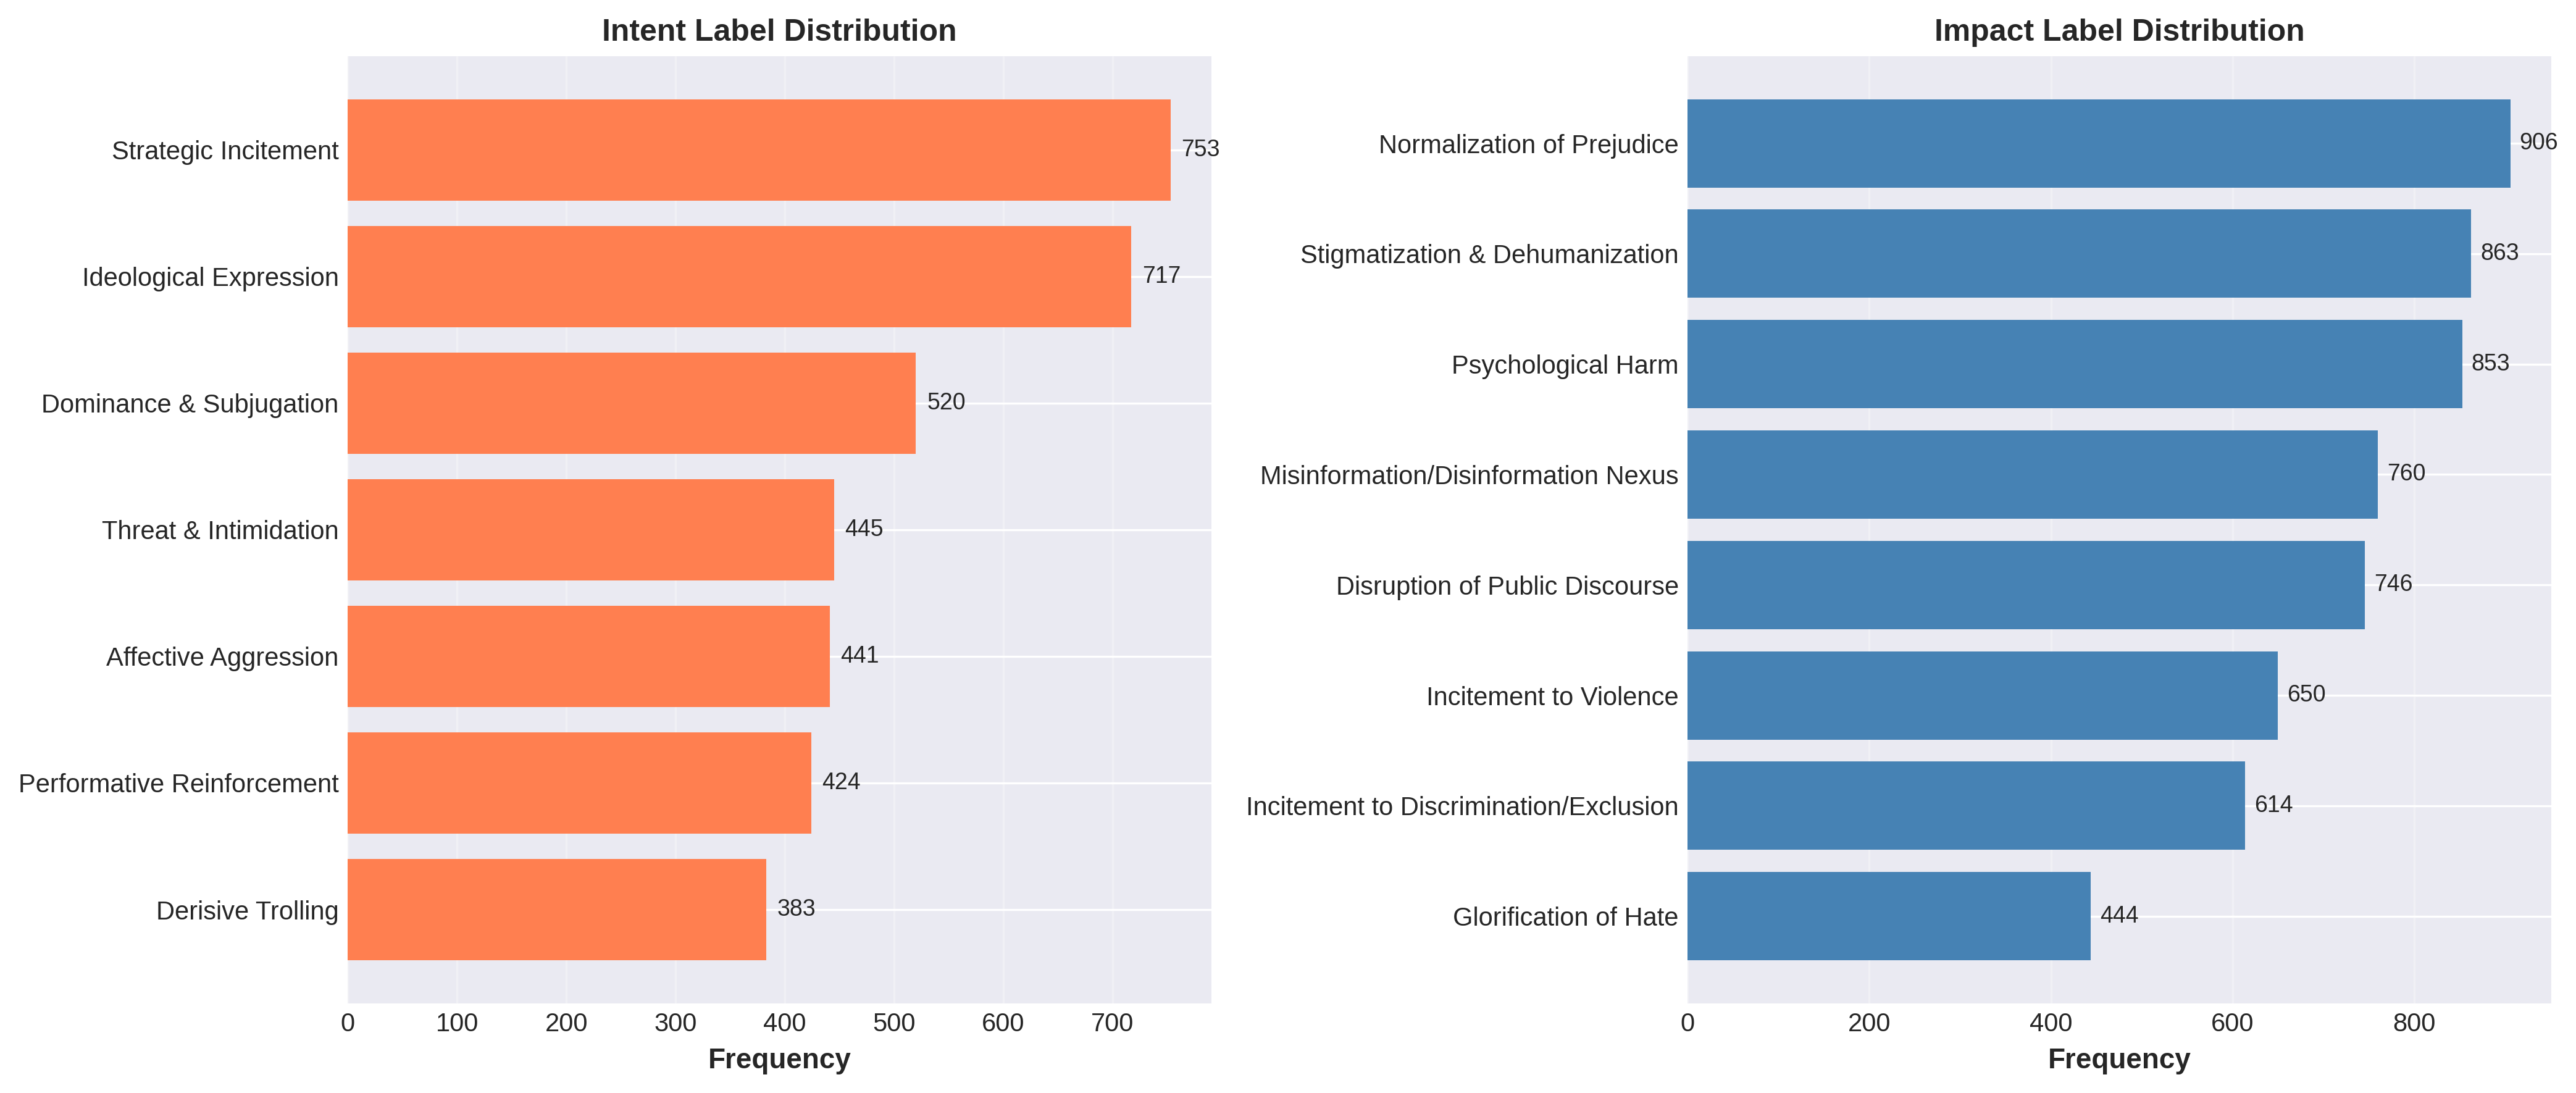

In [ ]:
# ============================================================================
# APPENDIX A1: LABEL DISTRIBUTION
# ============================================================================

def create_label_distribution(intent_encoded, impact_encoded, intent_labels, impact_labels):
    """
    Create horizontal bar charts showing label frequencies.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Intent frequencies
    intent_counts = intent_encoded.sum(axis=0)
    intent_df = pd.DataFrame({
        'Label': intent_labels,
        'Count': intent_counts
    }).sort_values('Count', ascending=True)

    ax1.barh(intent_df['Label'], intent_df['Count'], color='coral')
    ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Intent Label Distribution', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Add count labels
    for i, (label, count) in enumerate(zip(intent_df['Label'], intent_df['Count'])):
        ax1.text(count + 10, i, str(int(count)), va='center', fontsize=9)

    # Impact frequencies
    impact_counts = impact_encoded.sum(axis=0)
    impact_df = pd.DataFrame({
        'Label': impact_labels,
        'Count': impact_counts
    }).sort_values('Count', ascending=True)

    ax2.barh(impact_df['Label'], impact_df['Count'], color='steelblue')
    ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Impact Label Distribution', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # Add count labels
    for i, (label, count) in enumerate(zip(impact_df['Label'], impact_df['Count'])):
        ax2.text(count + 10, i, str(int(count)), va='center', fontsize=9)

    plt.tight_layout()

    return fig

# Generate figure
fig = create_label_distribution(intent_encoded, impact_encoded, INTENT_LABELS, IMPACT_LABELS)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a1_label_distribution.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES/appendix_a2_post_length_by_intent.pdf


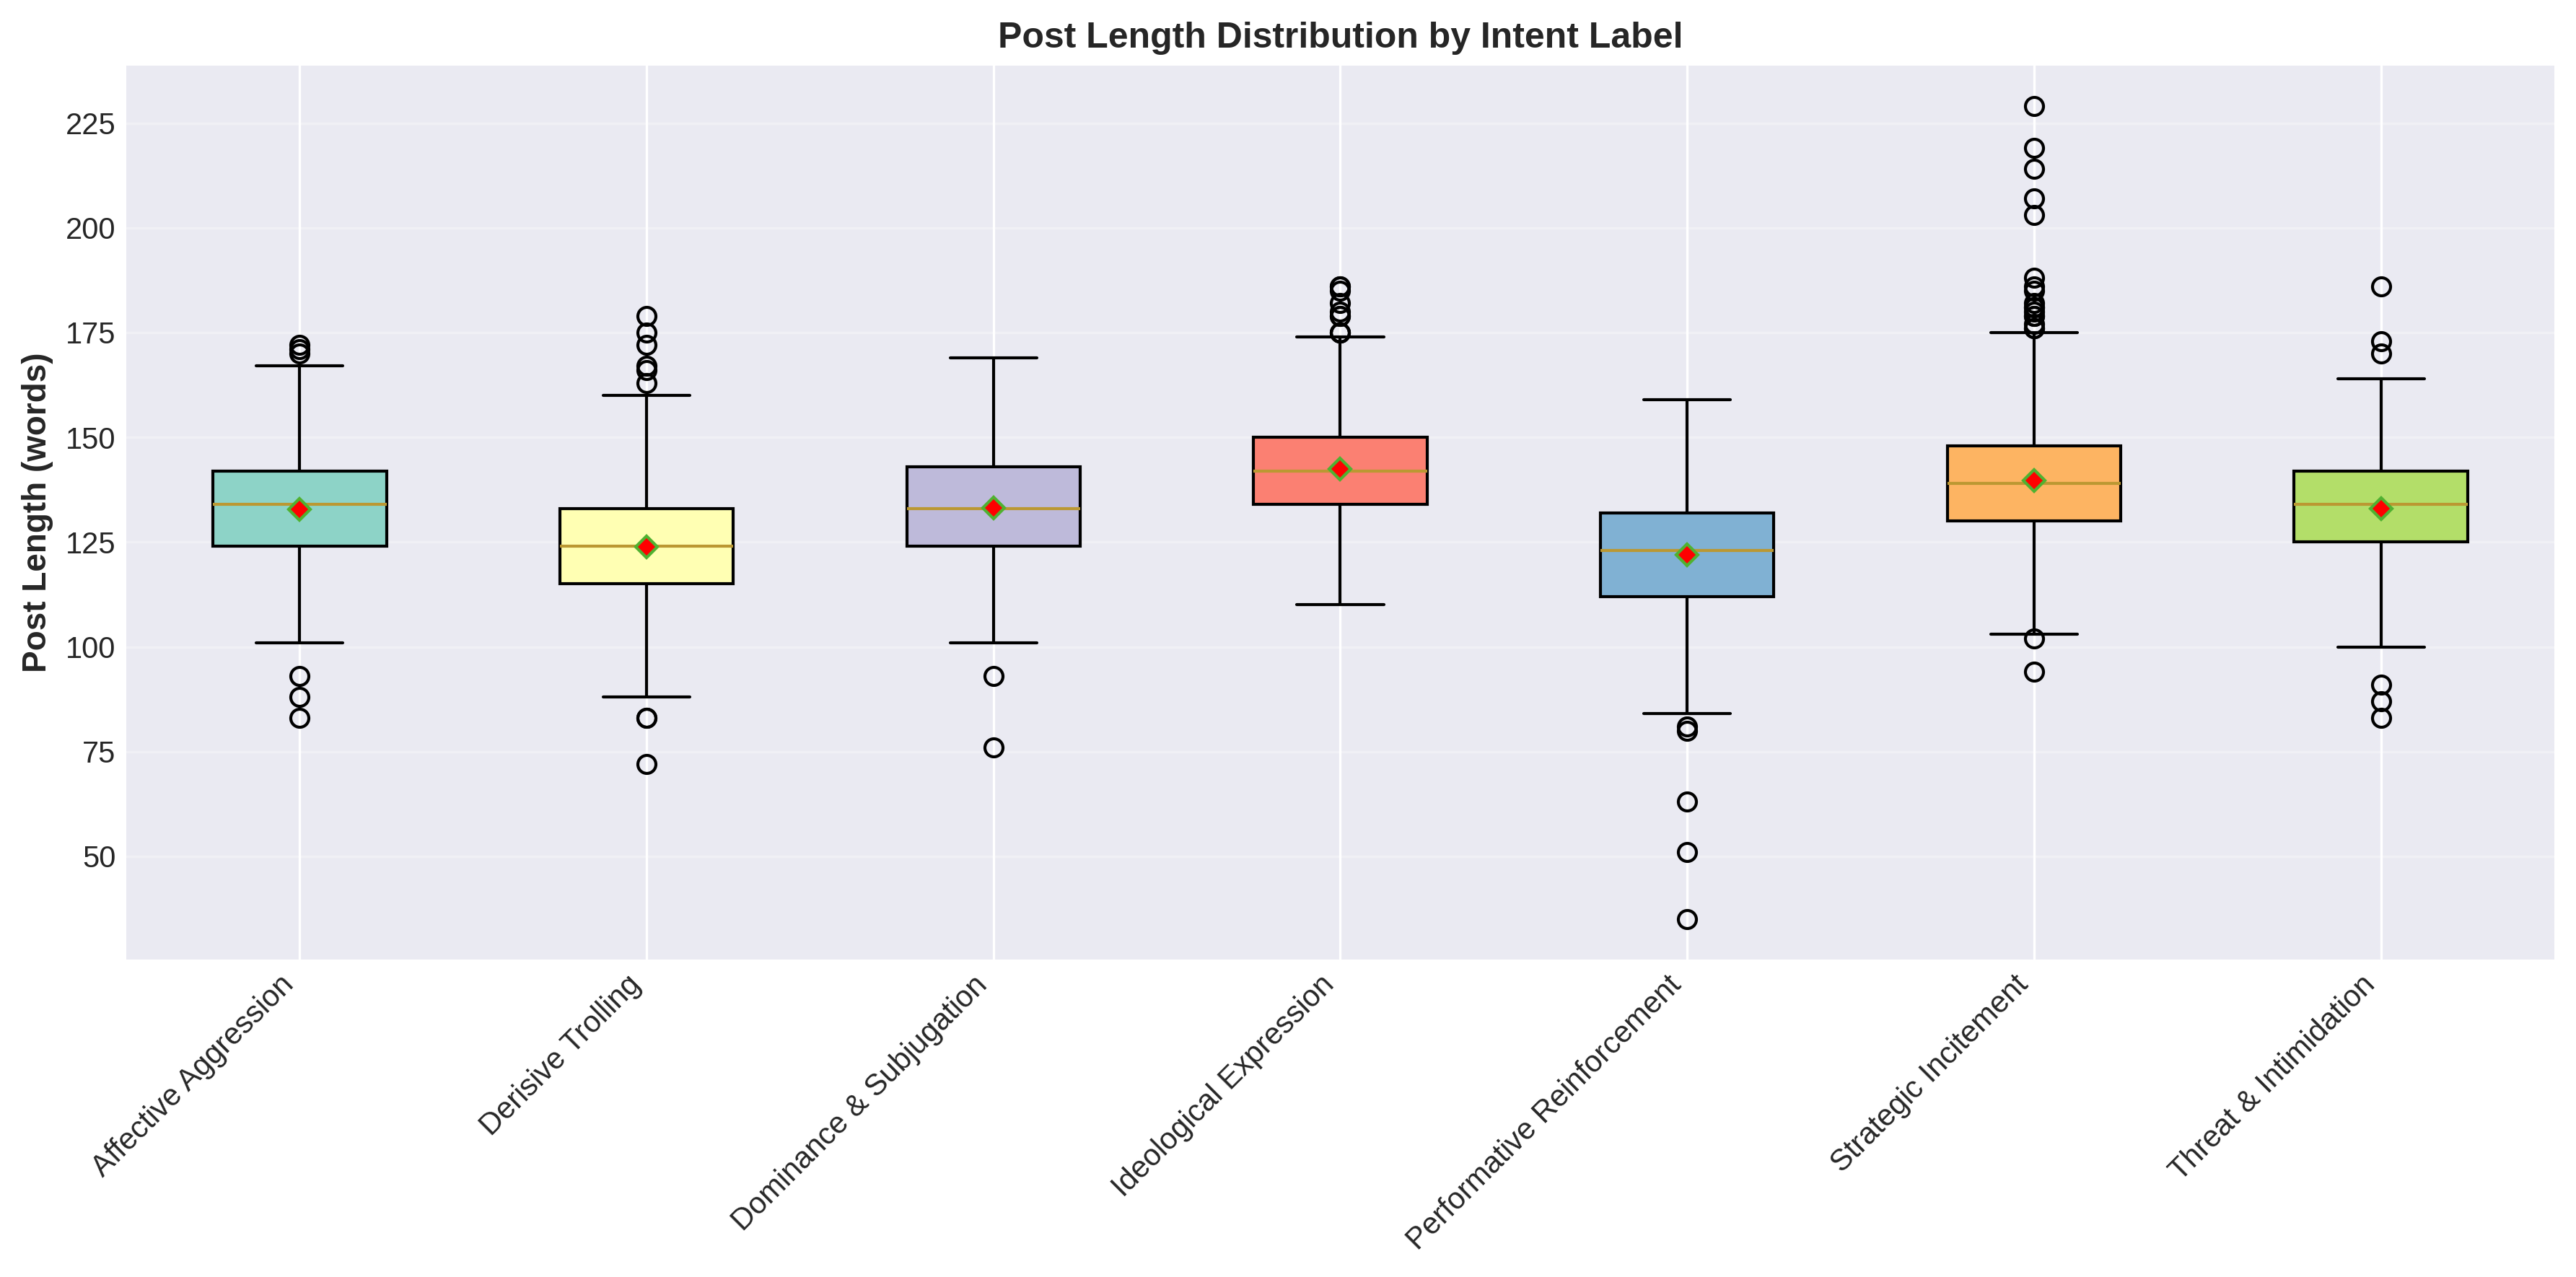

In [ ]:
# ============================================================================
# APPENDIX A2: POST LENGTH DISTRIBUTION BY INTENT
# ============================================================================

def create_post_length_distribution(texts, labels_encoded, label_names):
    """
    Create box plots showing post length distribution per label.
    """
    # Calculate post lengths
    post_lengths = [len(text.split()) for text in texts]

    # Organize data by label
    length_by_label = {label: [] for label in label_names}

    for length, sample_labels in zip(post_lengths, labels_encoded):
        for i, has_label in enumerate(sample_labels):
            if has_label:
                length_by_label[label_names[i]].append(length)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Prepare data for box plot
    data_to_plot = [length_by_label[label] for label in label_names]

    bp = ax.boxplot(data_to_plot,
                    labels=label_names,
                    patch_artist=True,
                    showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=5))

    # Color boxes
    colors = plt.cm.Set3(range(len(label_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel('Post Length (words)', fontsize=11, fontweight='bold')
    ax.set_title('Post Length Distribution by Intent Label', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return fig

# Generate figure
fig = create_post_length_distribution(texts, intent_encoded, INTENT_LABELS)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a2_post_length_by_intent.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES/appendix_a3_multilabel_density.pdf


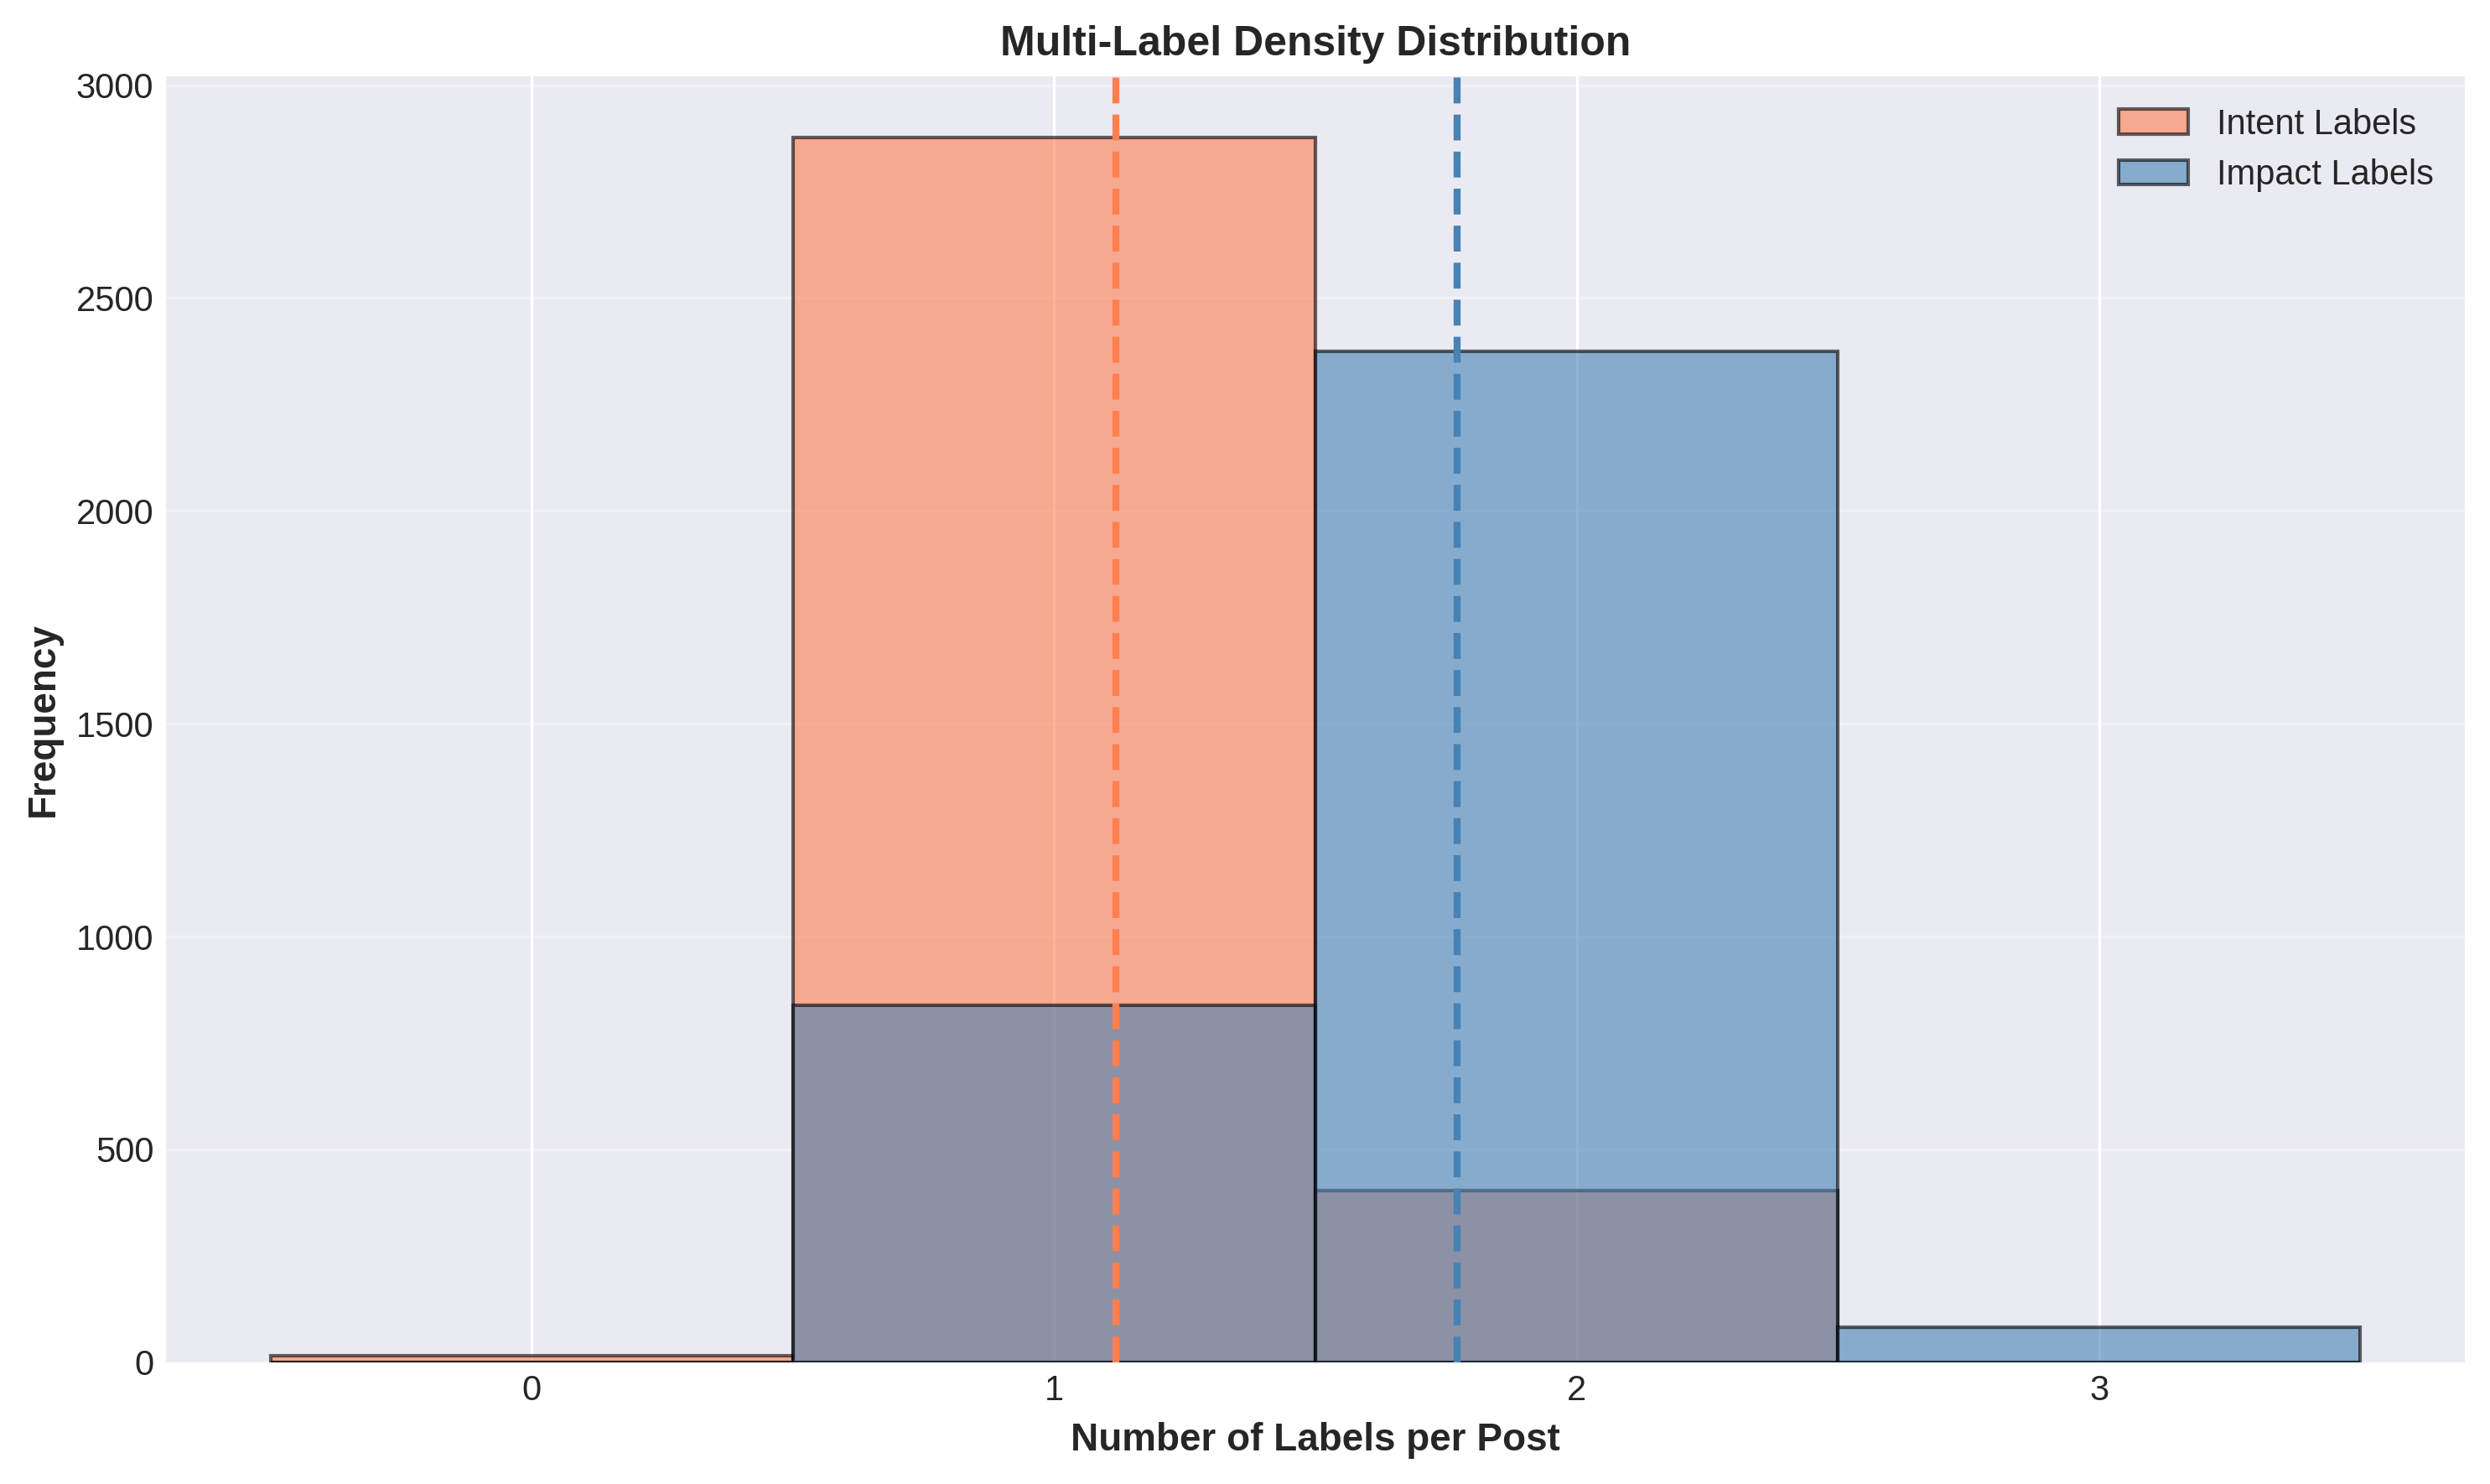

In [ ]:
# ============================================================================
# APPENDIX A3: MULTI-LABEL DENSITY HISTOGRAM
# ============================================================================

def create_multilabel_density(intent_encoded, impact_encoded):
    """
    Create histogram showing distribution of number of labels per post.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count labels per post
    intent_counts = intent_encoded.sum(axis=1)
    impact_counts = impact_encoded.sum(axis=1)

    # Create bins
    max_count = max(intent_counts.max(), impact_counts.max())
    bins = np.arange(0, max_count + 2) - 0.5

    # Plot histograms
    ax.hist(intent_counts, bins=bins, alpha=0.6, label='Intent Labels', color='coral', edgecolor='black')
    ax.hist(impact_counts, bins=bins, alpha=0.6, label='Impact Labels', color='steelblue', edgecolor='black')

    ax.set_xlabel('Number of Labels per Post', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title('Multi-Label Density Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticks(range(int(max_count) + 1))

    # Add mean lines
    ax.axvline(intent_counts.mean(), color='coral', linestyle='--', linewidth=2,
               label=f'Intent Mean: {intent_counts.mean():.2f}')
    ax.axvline(impact_counts.mean(), color='steelblue', linestyle='--', linewidth=2,
               label=f'Impact Mean: {impact_counts.mean():.2f}')

    plt.tight_layout()

    return fig

# Generate figure
fig = create_multilabel_density(intent_encoded, impact_encoded)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a3_multilabel_density.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

Saved: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES/appendix_a4_ngrams_by_intent.pdf


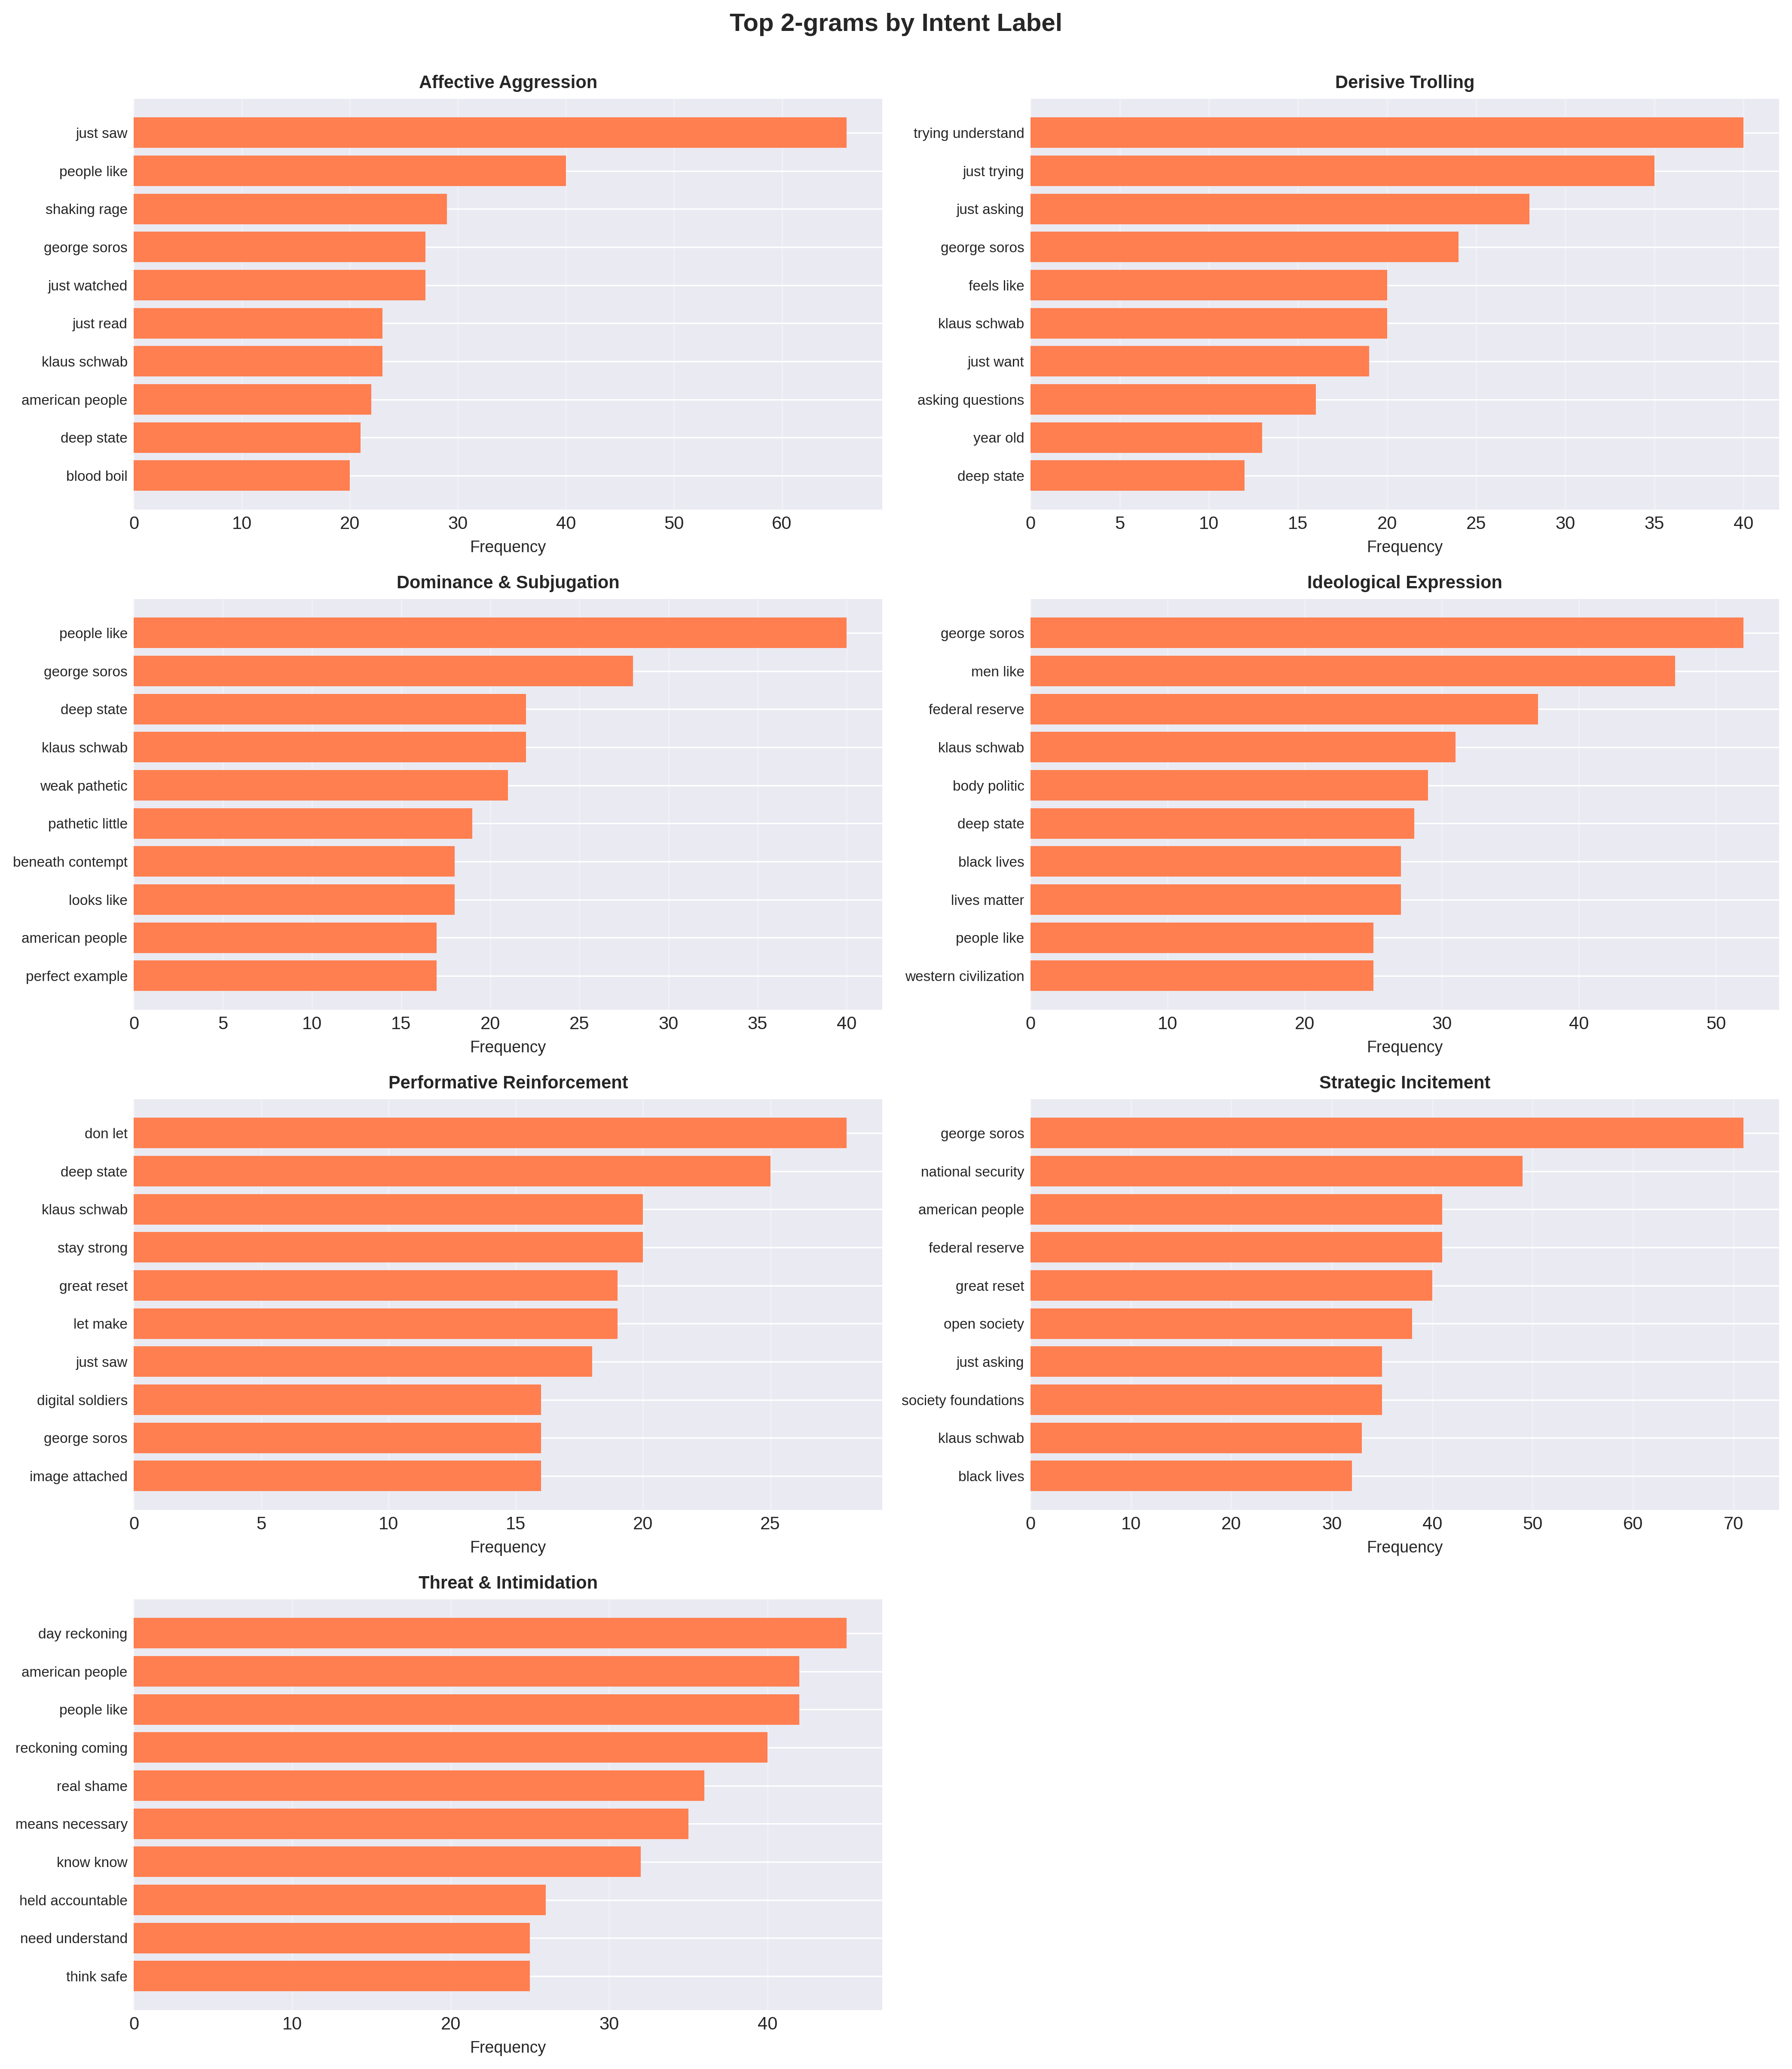

In [ ]:
# ============================================================================
# APPENDIX A4: TOP N-GRAMS PER INTENT LABEL
# ============================================================================

def extract_ngrams(texts, n=2):
    """Extract n-grams from texts."""
    from sklearn.feature_extraction.text import CountVectorizer

    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=20,
                                 stop_words='english', lowercase=True)

    try:
        X = vectorizer.fit_transform(texts)
        ngrams = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1
        return list(zip(ngrams, counts))
    except:
        return []

def create_ngram_analysis(texts, labels_encoded, label_names, n=2):
    """
    Create bar charts showing top n-grams for each intent label.
    """
    # Calculate number of subplots needed
    n_labels = len(label_names)
    n_cols = 2
    n_rows = (n_labels + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for idx, label in enumerate(label_names):
        # Get texts for this label
        label_mask = labels_encoded[:, idx] == 1
        label_texts = [text for text, has_label in zip(texts, label_mask) if has_label]

        if len(label_texts) == 0:
            axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[idx].set_title(label, fontsize=10, fontweight='bold')
            continue

        # Extract n-grams
        ngrams = extract_ngrams(label_texts, n=n)

        if len(ngrams) > 0:
            ngrams_sorted = sorted(ngrams, key=lambda x: x[1], reverse=True)[:10]
            words, counts = zip(*ngrams_sorted)

            axes[idx].barh(range(len(words)), counts, color='coral')
            axes[idx].set_yticks(range(len(words)))
            axes[idx].set_yticklabels(words, fontsize=8)
            axes[idx].set_xlabel('Frequency', fontsize=9)
            axes[idx].set_title(label, fontsize=10, fontweight='bold')
            axes[idx].grid(axis='x', alpha=0.3)
            axes[idx].invert_yaxis()

    # Hide unused subplots
    for idx in range(n_labels, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Top {n}-grams by Intent Label', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()

    return fig

# Generate figure
fig = create_ngram_analysis(texts, intent_encoded, INTENT_LABELS, n=2)

# Save
output_path = os.path.join(OUTPUT_DIR, 'appendix_a4_ngrams_by_intent.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Saved: {output_path}")

plt.show()

In [ ]:
# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("ALL FIGURES GENERATED SUCCESSFULLY")
print("="*80)
print(f"\nOutput directory: {OUTPUT_DIR}")
print("\nGenerated figures:")
print("- fig1_correlation_matrix.pdf (Main Paper)")
print("- fig2a_umap_intent.pdf (Main Paper)")
print("- fig2b_umap_impact.pdf (Main Paper)")
print("- appendix_a1_label_distribution.pdf")
print("- appendix_a2_post_length_by_intent.pdf")
print("- appendix_a3_multilabel_density.pdf")
print("- appendix_a4_ngrams_by_intent.pdf")
print("="*80)


ALL FIGURES GENERATED SUCCESSFULLY

Output directory: /content/drive/MyDrive/🌟EACL 2026 🌟/REVAMPED PROJECT 1 FIGURES

Generated figures:
- fig1_correlation_matrix.pdf (Main Paper)
- fig2a_umap_intent.pdf (Main Paper)
- fig2b_umap_impact.pdf (Main Paper)
- appendix_a1_label_distribution.pdf
- appendix_a2_post_length_by_intent.pdf
- appendix_a3_multilabel_density.pdf
- appendix_a4_ngrams_by_intent.pdf
